# Probability of Informed Trading

A PIN example using the UST Wormhole pool. Notice how PIN does not seem to meaningfully correlate with the actual UST depeg.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
import os
import sys
import requests as req
import json

from datetime import datetime, timedelta

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

new_path = os.getcwd().replace('/notebooks', '')
print(f'Adding {new_path} to sys.path')

if new_path not in sys.path:
    sys.path.append(new_path)

# Local imports
from curvemetrics.src.classes.datahandler import DataHandler
from curvemetrics.src.classes.datafetcher import DataFetcher
from curvemetrics.src.classes.metricsprocessor import MetricsProcessor

Adding /root/curve-lp-metrics to sys.path


In [ ]:
plt.rcParams["font.family"] = "serif"
plt.rcParams.update({'font.size': 10})

In [ ]:
datahandler = DataHandler()
token_metadata = datahandler.get_token_metadata()
pool_metadata = datahandler.get_pool_metadata()

pool = "0xceaf7747579696a2f0bb206a14210e3c9e6fb269" # UST

start_ts, start_block = DataFetcher.get_block(datetime.fromisoformat("2022-05-01"))
end_ts, end_block = DataFetcher.get_block(datetime.fromisoformat("2022-05-20"))

In [ ]:
swaps_data = datahandler.get_swaps_data(pool, start_ts, end_ts)
lp_data = datahandler.get_lp_data(pool, start_ts, end_ts)
pool_data = datahandler.get_pool_data(pool, start_ts, end_ts)

In [ ]:
tokens = {token_metadata[v]['symbol']:v for v in set(swaps_data['tokenBought'])}
tokens

<Axes: xlabel='timestamp'>

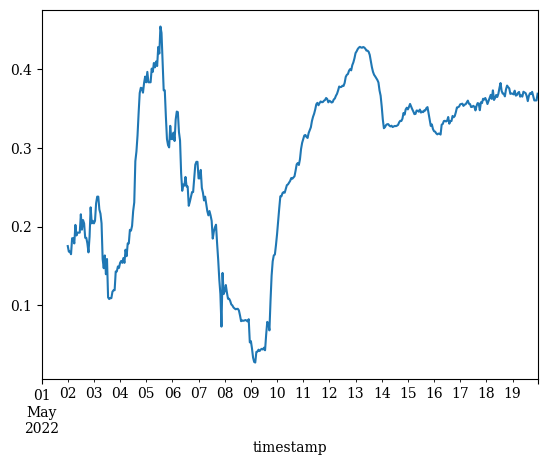

In [ ]:
pin = MetricsProcessor.rolling_pin(swaps_data, tokens['UST'], 'UST', window=timedelta(days=1), freq=timedelta(hours=1))
pin.plot()

<Axes: xlabel='timestamp'>

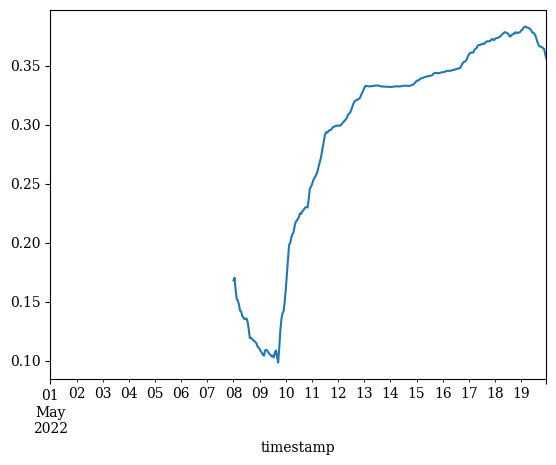

In [ ]:
pin = MetricsProcessor.rolling_pin(swaps_data, tokens['UST'], 'UST', window=timedelta(days=7), freq=timedelta(hours=1))
pin.plot()

<Axes: xlabel='timestamp'>

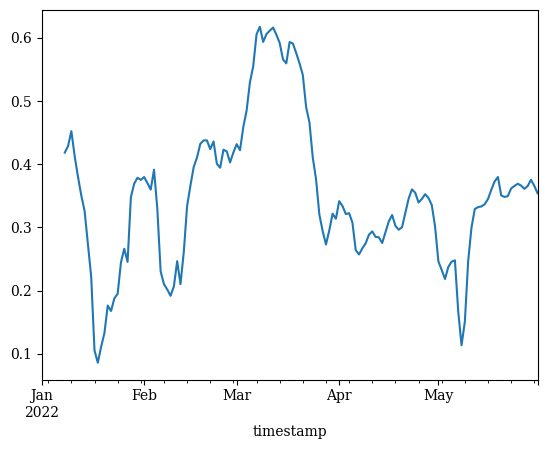

In [ ]:
long_start_ts, _ = DataFetcher.get_block(datetime.fromisoformat("2022-01-01"))
long_end_ts, _ = DataFetcher.get_block(datetime.fromisoformat("2022-06-01"))
long_swaps_data = datahandler.get_swaps_data(pool, long_start_ts, long_end_ts)
pin = MetricsProcessor.rolling_pin(long_swaps_data, tokens['UST'], 'UST', window=timedelta(days=7), freq=timedelta(days=1))
pin.plot()

In [ ]:
ohlcvs = {}
for k, v in tokens.items():
    if k == "3Crv":
        continue
    ohlcv = datahandler.get_ohlcv_data(v, start=long_start_ts, end=long_end_ts)
    ohlcvs[k] = ohlcv

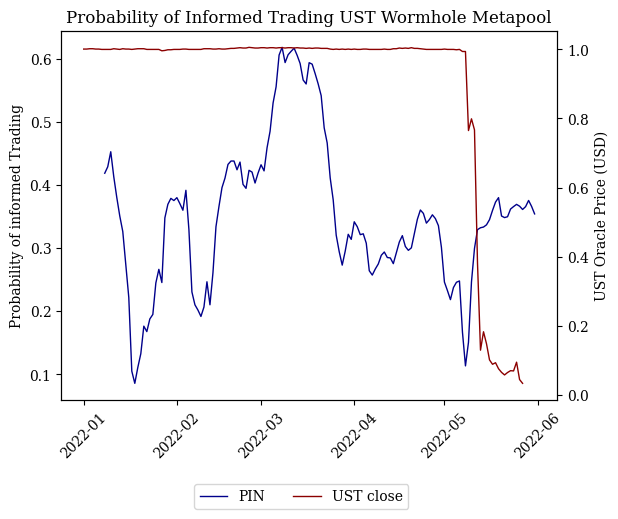

In [ ]:
f, ax = plt.subplots()
ax2 = ax.twinx()
ust_prices = ohlcvs['UST']['close'].resample('1d').last()
ax.plot(pin.index, pin, label="PIN", c='darkblue', linewidth=1)
ax2.plot(ust_prices.index, ust_prices, label="UST close", c='darkred', linewidth=1)

ax.set_title('Probability of Informed Trading UST Wormhole Metapool')
ax.set_ylabel("Probability of informed Trading")
ax2.set_ylabel("UST Oracle Price (USD)")
ax.tick_params(axis='x', rotation=45)

f.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), ncol=2)
f.savefig('../figs/pin_ust.png', bbox_inches='tight')